## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Gustavo Marques

This notebooks servers as an example on how to extract surface (or any other 2D spatial field) properties from a selected spacial region accross all LENS2 members

## Imports

In [1]:
import intake
import intake_esm
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import fsspec
import cmocean
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pop_tools
import sys
from distributed import Client
from ncar_jobqueue import NCARCluster
sys.path.append('../functions')
import util
from cartopy.util import add_cyclic_point
from misc import get_ij
import warnings, getpass, os

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


<div class="alert alert-block alert-info">
<b>Note:</b> comment the following line when debugging
</div>

In [2]:
warnings.filterwarnings("ignore")

### Local functions

In [3]:
def rms_da(da, dims=('nlat', 'nlon'), weights=None,  weights_sum=None):
  """
  Calculates the rms in DataArray da (optional weighted rms).

  ----------
  da : xarray.DataArray
        DataArray for which to compute (weighted) rms.

  dims : tuple, str
    Dimension(s) over which to apply reduction. Default is ('yh', 'xh').

  weights : xarray.DataArray, optional
    weights to apply. It can be a masked array.

  weights_sum : xarray.DataArray, optional
    Total weight (i.e., weights.sum()). Only computed if not provided.

  Returns
  -------
  reduction : DataSet
      xarray.Dataset with (optionally weighted) rms for da.
  """

  if weights is not None:
    if weights_sum is None: weights_sum = weights.sum(dim=dims)
    out = np.sqrt((da**2 * weights).sum(dim=dims)/weights_sum)
    # copy attrs
    out.attrs = da.attrs
    return out
  else:
    return np.sqrt((da**2).mean(dim=dims, keep_attrs=True))

### Dask workers

In [4]:
cluster = NCARCluster(cores=4,
    processes=1,
    resource_spec='select=1:ncpus=1:mem=25GB',
)
cluster.scale(80)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.56:45342,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Data Ingest

In [5]:
%%time
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

CPU times: user 27.3 s, sys: 1.5 s, total: 28.8 s
Wall time: 29.3 s


In [6]:
catalog.search(component='ocn').unique('frequency')

{'frequency': {'count': 3, 'values': ['year_1', 'day_1', 'month_1']}}

In [7]:
# this prints all ocean variables that have montly frequency
#catalog.search(component='ocn', frequency='month_1').unique('variable')

### Let's search for TEMP with montly frequency

In [8]:
cat_subset = catalog.search(component='ocn',
                            frequency='month_1',
                            variable='TEMP')

In [9]:
%%time
dset_dict_raw = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 29.6 s, sys: 1.35 s, total: 30.9 s
Wall time: 40.5 s


In [10]:
# print keys
[key for key in dset_dict_raw.keys()]

['ocn.historical.pop.h.smbb.TEMP',
 'ocn.historical.pop.h.cmip6.TEMP',
 'ocn.ssp370.pop.h.smbb.TEMP',
 'ocn.ssp370.pop.h.cmip6.TEMP']

In [11]:
ds_hist_cmip6 = dset_dict_raw['ocn.historical.pop.h.cmip6.TEMP'] 

In [12]:
ds_hist_smbb = dset_dict_raw['ocn.historical.pop.h.smbb.TEMP'] 

In [13]:
ds_all = xr.concat([ds_hist_cmip6,ds_hist_smbb], dim='member_id', 
                     data_vars='minimal',coords="minimal",
                     compat="override")
ds_all.TEMP.nbytes*1e-12 # in TB

5.8392576

In [14]:
ds_all.TEMP

<xarray.DataArray 'TEMP' (member_id: 100, time: 1980, z_t: 60, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(100, 1980, 60, 384, 320), dtype=float32, chunksize=(1, 120, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1171p1f2'
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

### Import the POP grid

If you choose the ocean component of LENS2, you will need to import the POP grid. For the other components, you can use the emsemble's own grid. 

In ds, TLONG and TLAT have missing values (NaNs), so we need to override them with the values from pop_grid, which does not have missing values.

In [15]:
# Read the pop 1 deg grid from pop_tools
# We will use variables TLONG and TLAT
pop_grid = pop_tools.get_grid('POP_gx1v7')
ds_all['TLONG'] = pop_grid.TLONG   # Longitud
ds_all['TLAT'] = pop_grid.TLAT     # Latitudes

### Plot SST

In [16]:
%%time
temp_tmp = ds_all.TEMP.isel(member_id=0, time=0, z_t=0)#.plot()

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 2.85 ms


CPU times: user 4.08 s, sys: 64.7 ms, total: 4.14 s
Wall time: 20.3 s


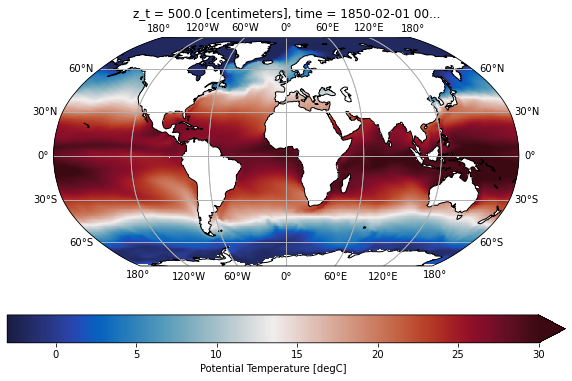

In [17]:
%%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = temp_tmp.plot.pcolormesh(ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.balance,
                    x='TLONG',
                    y='TLAT',
                    vmin=-3,
                    vmax=30,
                    cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines();

### Centralize the South Atlantic 
Need to combine the domain in the east/west direction to centralize the South Atlantic

In [18]:
sa_ds=xr.combine_nested([
     [ds_all.isel(nlat = slice(115,190),nlon = slice(300,320)),
      ds_all.isel(nlat = slice(115,190),nlon = slice(0,60))]],
    concat_dim=['nlat','nlon']
)

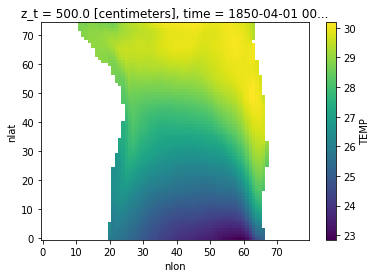

In [19]:
# simple check
sa_ds.TEMP.isel(time=2, member_id=0, z_t=0).plot()

CPU times: user 504 ms, sys: 65.3 ms, total: 570 ms
Wall time: 17.9 s


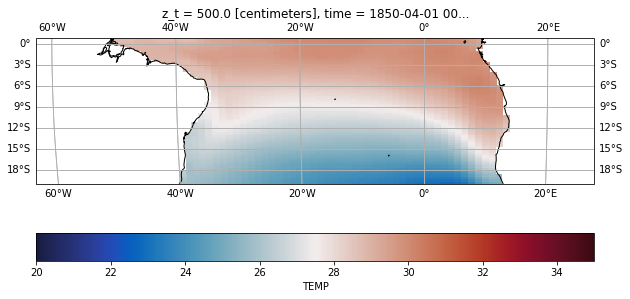

In [20]:
%%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = sa_ds.TEMP.isel(time=2, member_id=0, z_t=0).plot.pcolormesh(ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.balance,
                    x='TLONG',
                    y='TLAT',
                    vmin=20,
                    vmax=35,
                    cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines();

### Extract correponding area 

In [21]:
area_sa = xr.combine_nested([
    
    [pop_grid.TAREA.isel(nlat = slice(115,190),nlon = slice(300,320)),
      pop_grid.TAREA.isel(nlat = slice(115,190),nlon = slice(0,60))]],
    concat_dim=['nlat','nlon']
)

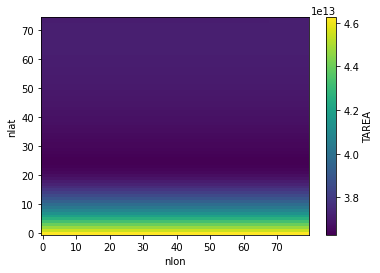

In [22]:
# simple check
area_sa.plot();

### Select time window 
<div class="alert alert-block alert-info">
<b>Note:</b> we should process the entire dataset once we fix the issue with Dask
</div>

In [23]:
start="1982-01-01"
end="2014-12-31"
sst = sa_ds.TEMP.isel(z_t=0).sel(time=slice(start,end))

### Perfom computations
Calculate area mean, min, max, and rms for the surface temperature of the selected region

In [24]:
# area weighted sst
sst_mean = sst.weighted(area_sa).mean(dim=("nlon", "nlat")).load()

In [25]:
# max sst
sst_max = sst.max(dim=("nlon", "nlat")).load()

In [26]:
# min sst
sst_min = sst.min(dim=("nlon", "nlat")).load()

In [27]:
# sst rms
sst_rms = rms_da(sst, weights=area_sa,  weights_sum=area_sa.sum()).load()

### TODO
plot some time series to check calculations

### Merge data and save on disk

In [29]:
ds_out = xr.merge([sst_rms.rename('sst_rms'),
                    sst_mean.rename('sst_mea'),
                    sst_max.rename('sst_max'),
                    sst_min.rename('sst_min')])

# TODO: add more attrs e.g., date it was create, by who (name, email), 
## improve description, add lat/lon region etc
ds_out.attrs['description'] = 'sst statistics for the South Atlantic'

In [30]:
# create a directory on scratch to save the output
path = '/glade/scratch/{}/LENS2_south_atlantic/SST/'.format(getpass.getuser())
os.system('mkdir -p '+path)

0

In [31]:
ds_out.to_netcdf(path+'sst_stats.nc')

In [ ]:
cluster.close()
client.close()